In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('../DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [3]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
df.columns = ['Sales']

In [5]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


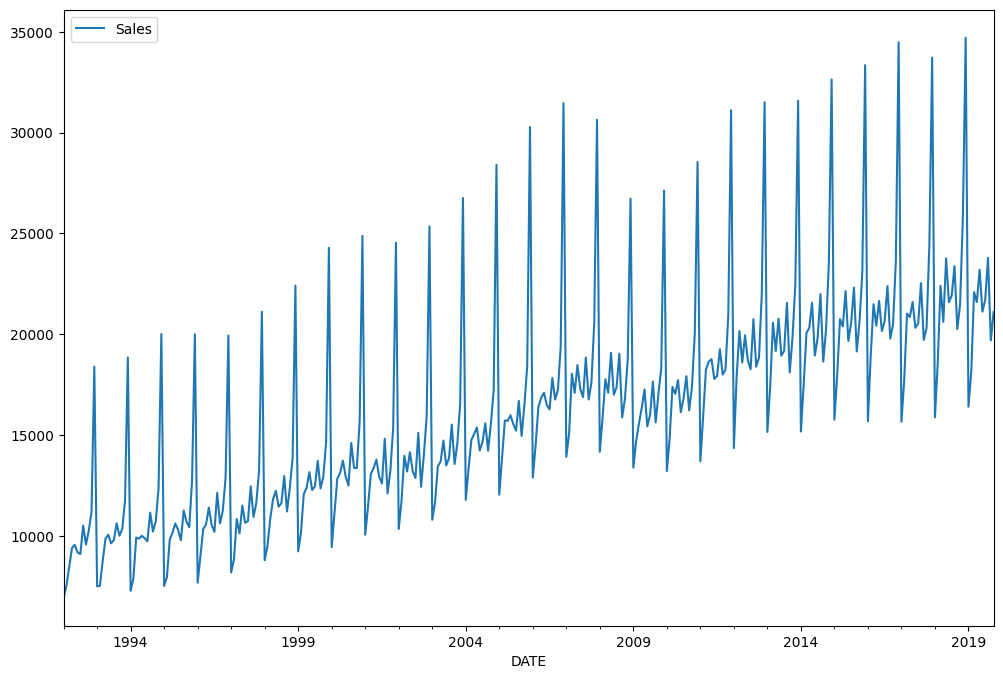

In [6]:
df.plot(figsize=(12,8))
plt.show()

In [7]:
len(df)

334

In [8]:
len(df) - 18

316

In [9]:
test_size = 18
test_index = len(df) - test_size

In [10]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [14]:
batch_size = 1
length = 12
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length, batch_size=batch_size)

In [15]:
x, y = generator[0]

In [16]:
x

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [17]:
y

array([[0.02047633]])

In [18]:
x, y = generator[1]

In [19]:
x

array([[[0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266],
        [0.02047633]]])

In [20]:
y

array([[0.02127505]])

In [34]:
layers = tf.keras.layers

In [88]:
model ='model'

In [104]:
num_features = 1
model = tf.keras.models.Sequential([
    layers.LSTM(100, input_shape=(length, num_features), activation='relu'),
    layers.Dense(1),
])

model.compile(loss='mse', optimizer='adam')

In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [106]:
val_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=batch_size)

In [107]:
model.fit(generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])

Epoch 1/20
304/304 [==============================] - 4s 7ms/step - loss: 0.0229 - val_loss: 0.0308
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0155 - val_loss: 0.0080
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss: 0.0023
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0051 - val_loss: 0.0075
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0023 - val_loss: 0.0024


In [108]:
losses = pd.DataFrame(model.history.history)

<Axes: >

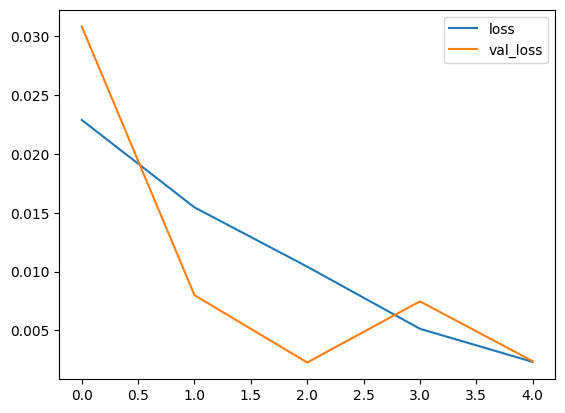

In [109]:
losses.plot()

In [110]:
first_batch = scaled_train[-length:].reshape(1,length,num_features)

In [111]:
model.predict(first_batch)

1/1 [==============================] - 0s 234ms/step


array([[0.5590986]], dtype=float32)

In [112]:
scaled_test[0]

array([0.61087714])

In [113]:
test_predictions = []
batch = scaled_train[-length:].reshape(1, length, num_features)

for _ in range(len(scaled_test)):
    pred = model.predict(batch)
    test_predictions.append(pred[0])
    batch = np.append(batch[:,1:,:], [pred], axis=1)

1/1 [==============================] - 0s 32ms/step


In [114]:
test_predictions

[array([0.5590986], dtype=float32),
 array([0.5131801], dtype=float32),
 array([0.5230991], dtype=float32),
 array([0.5969401], dtype=float32),
 array([0.49669576], dtype=float32),
 array([0.52535385], dtype=float32),
 array([0.6858952], dtype=float32),
 array([1.1479563], dtype=float32),
 array([0.35247192], dtype=float32),
 array([0.4476552], dtype=float32),
 array([0.58828604], dtype=float32),
 array([0.5258368], dtype=float32),
 array([0.59189045], dtype=float32),
 array([0.54608786], dtype=float32),
 array([0.55913144], dtype=float32),
 array([0.6377448], dtype=float32),
 array([0.53914], dtype=float32),
 array([0.57900447], dtype=float32)]

In [115]:
true_predictions = scaler.inverse_transform(test_predictions)

In [116]:
test['Predictions'] = true_predictions

C:\Users\Nagant\AppData\Local\Temp\ipykernel_9596\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='DATE'>

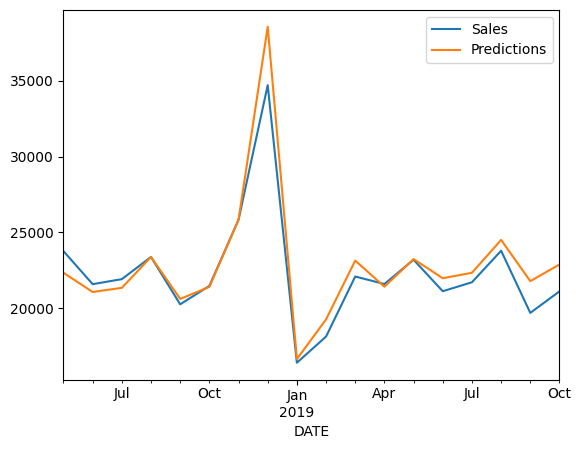

In [117]:
test.plot()

In [118]:
full_scaled_data = scaler.fit_transform(df)

In [119]:
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(data=full_scaled_data, targets=full_scaled_data, length=length, batch_size=batch_size)

In [124]:
full_model = tf.keras.models.Sequential([
    layers.LSTM(100, input_shape=(length, num_features), activation='relu'),
    layers.Dense(1)
])

full_model.compile(loss='mse', optimizer='adam')

In [125]:
full_model.fit(generator, epochs=7)

Epoch 1/7
322/322 [==============================] - 5s 9ms/step - loss: 0.0246
Epoch 2/7
322/322 [==============================] - 3s 9ms/step - loss: 0.0165
Epoch 3/7
322/322 [==============================] - 3s 9ms/step - loss: 0.0090
Epoch 4/7
322/322 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 5/7
322/322 [==============================] - 2s 7ms/step - loss: 0.0025
Epoch 6/7
322/322 [==============================] - 3s 9ms/step - loss: 0.0017
Epoch 7/7
322/322 [==============================] - 6s 18ms/step - loss: 0.0024


In [126]:
forecast = []
batch = scaled_train[-length:].reshape(1, length, num_features)
periods = 12

for _ in range(periods):
    pred = model.predict(batch)
    forecast.append(pred[0])
    batch = np.append(batch[:,1:,:], [pred], axis=1)

1/1 [==============================] - 0s 30ms/step


In [127]:
true_forecast = scaler.inverse_transform(forecast)

In [128]:
forecast

[array([0.5590986], dtype=float32),
 array([0.5131801], dtype=float32),
 array([0.5230991], dtype=float32),
 array([0.5969401], dtype=float32),
 array([0.49669576], dtype=float32),
 array([0.52535385], dtype=float32),
 array([0.6858952], dtype=float32),
 array([1.1479563], dtype=float32),
 array([0.35247192], dtype=float32),
 array([0.4476552], dtype=float32),
 array([0.58828604], dtype=float32),
 array([0.5258368], dtype=float32)]

In [129]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [131]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [132]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [139]:
forecast_df = pd.DataFrame(data=true_forecast, index=forecast_index, columns=['Forecast'])

In [140]:
forecast_df

,Forecast
2019-11-01,22463.049962
2019-12-01,21187.984380
2020-01-01,21463.416487
2020-02-01,23513.832702
2020-03-01,20730.247778
2020-04-01,21526.025677
2020-05-01,25983.938040
2020-06-01,38814.449208
2020-07-01,16725.440215
2020-08-01,19368.489620


<Axes: >

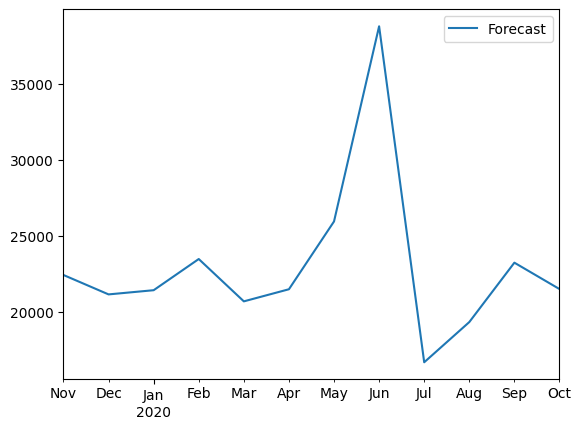

In [141]:
forecast_df.plot()

<Axes: xlabel='DATE'>

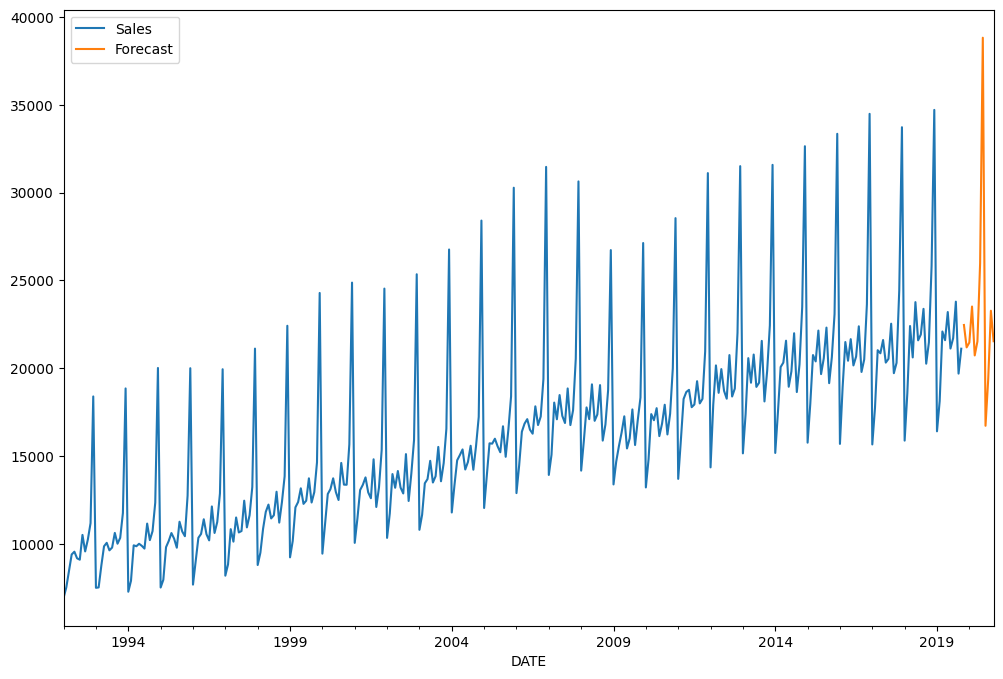

In [143]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)

(576.0, 611.0)

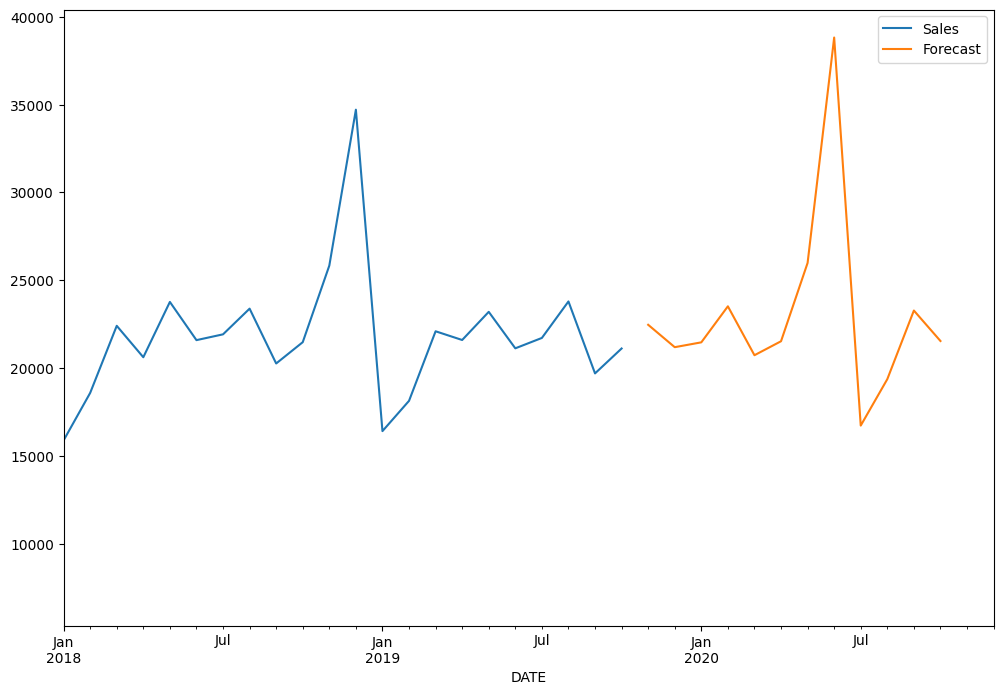

In [144]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01')